In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import imgaug.augmenters as iaa
import imgaug as ia
from tqdm.notebook import trange
import pandas as pd

background_imgs_path = 'data/vk_small/'
templates_imgs_path = 'data/templates/'
augmented_templates_number = 1024
cascade_img_size = 512

In [2]:
background_imgs = []
template_imgs = []
for img_path in os.listdir(templates_imgs_path):
    template = cv2.imread(os.path.join(templates_imgs_path, img_path), 0)
    template = cv2.resize(template, (256, 256))
    
    _, template_orig = cv2.threshold(template, 180, 255, cv2.THRESH_BINARY_INV)
    template_orig = cv2.cvtColor(template_orig, cv2.COLOR_GRAY2RGB)
    template_imgs.append(template_orig)
    template_imgs.append(255 - template_orig)
    
for img_path in os.listdir(background_imgs_path):
    img = cv2.imread(os.path.join(background_imgs_path, img_path))
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    background_imgs.append(img)
np.random.shuffle(background_imgs)

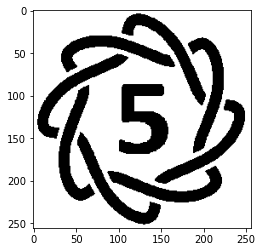

In [3]:
plt.imshow(template_imgs[3], cmap='Greys_r')

In [4]:
# seq.show_grid([images[0]], cols=8, rows=8)

In [5]:
# e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

# Define our sequence of augmentation steps that will be applied to every image
# All augmenters with per_channel=0.5 will sample one value _per image_
# in 50% of all cases. In all other cases they will sample new values
# _per channel_.

seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        iaa.AddToHueAndSaturation((-100, 100)), # change hue and saturation

        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.LinearContrast((0.5, 2.0))
                    )
                ]),
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)

C:\Anaconda3\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Function `SimplexNoiseAlpha()` is deprecated. Use `BlendAlphaSimplexNoise` instead. SimplexNoiseAlpha is deprecated. Use BlendAlphaSimplexNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)
C:\Anaconda3\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Function `FrequencyNoiseAlpha()` is deprecated. Use `BlendAlphaFrequencyNoise` instead. FrequencyNoiseAlpha is deprecated. Use BlendAlphaFrequencyNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)


In [6]:
n = augmented_templates_number // 4
tmp1 = [img[np.newaxis] for img in template_imgs]
tmp2 = [template_imgs[0][np.newaxis], template_imgs[2][np.newaxis],
        template_imgs[0][np.newaxis], template_imgs[2][np.newaxis]]

images = np.repeat(np.concatenate(tmp1), n, 0).reshape(-1, *template_imgs[0].shape)
masks = np.repeat(np.concatenate(tmp2), n, 0).reshape(-1, *template_imgs[0].shape).astype(np.float32) / 255
augmented_imgs, masks = seq(images=images, heatmaps=masks)

C:\Anaconda3\lib\site-packages\imgaug\augmenters\segmentation.py:272: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  image, n_segments=n_segments_samples[i], compactness=10)


In [7]:
indicies = np.arange(len(augmented_imgs))
np.random.shuffle(indicies)
augmented_imgs = augmented_imgs[indicies]
masks = masks[indicies]

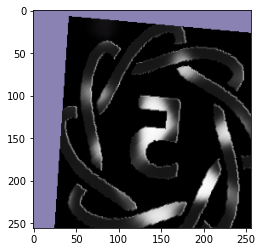

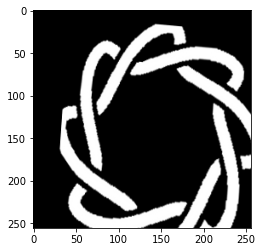

In [8]:
n = 28
augmented_img = augmented_imgs[n].copy()
mask = masks[n].copy()#augmented_img.sum(-1) > 30
plt.imshow(augmented_img)
plt.figure()
plt.imshow(mask, cmap='Greys_r')

In [9]:
dataset_goal = 'cascade2'

df_detector_answers = pd.DataFrame({'img_name': [], 'x': [], 'y': [], 'w': [], 'h': []})
df_detector_answers = df_detector_answers.astype({'x': 'int32', 'y': 'int32', 'w': 'int32', 'h': 'int32'})

for i in trange(1000):
    n = i % augmented_templates_number
    background_n = i % len(background_imgs)
    
    background = background_imgs[background_n].copy()
    augmented_img = augmented_imgs[n].copy()
    mask_orig = masks[n].copy()

    # Random resizing
    mask_orig *= 255
    x = np.random.randint(40, 500)
    y = int(x * (np.random.random() + 0.5) * 3 / 2)
    size = [x, y]
    augmented_img = cv2.bitwise_and(augmented_img, mask_orig.astype(np.uint8))
    augmented_img = cv2.resize(augmented_img, (*size,))
    mask = cv2.resize(mask_orig, (*size,))[..., 0]

    x = np.random.randint(0, background.shape[0] - augmented_img.shape[0])
    y = np.random.randint(0, background.shape[1] - augmented_img.shape[1])

    if dataset_goal == 'detector':
        big_mask = np.zeros(background.shape[:2], dtype=np.uint8)
        big_mask[x : x + augmented_img.shape[0], y : y + augmented_img.shape[1]] = mask

        big_augmented = np.zeros(background.shape, dtype=np.uint8)
        big_augmented[x : x + augmented_img.shape[0], y : y + augmented_img.shape[1]] = augmented_img

        big_mask = cv2.cvtColor(big_mask, cv2.COLOR_GRAY2RGB)

        background_masked = cv2.bitwise_and(~big_mask, background)


        blended = cv2.addWeighted(big_augmented, 1, background_masked, 1, 0)
#         blended = cv2.rectangle(blended, (y, x), (y + augmented_img.shape[1], x + augmented_img.shape[0]), (255, 0, 0), 1)

        
        folder = 'detector_data/'
        if not os.path.exists(folder):
            os.makedirs(folder)
        
        img_name = f'img-{i}.jpg'
        cv2.imwrite(f'{folder}/{img_name}', blended)
        df_detector_answers = df_detector_answers.append(
            {'img_name': img_name, 'x': int(x), 'y': int(y), 
             'w': int(augmented_img.shape[0]), 'h': int(augmented_img.shape[1])},
            ignore_index=True)
    
    elif dataset_goal == 'cascade':
        background_segment = background[x : x + augmented_img.shape[0], y : y + augmented_img.shape[1]]
        
        bg_mask = cv2.cvtColor(mask.astype(np.uint8), cv2.COLOR_GRAY2RGB)
        background_masked = cv2.bitwise_and(~bg_mask, background_segment)

        blended = cv2.addWeighted(augmented_img, 1, background_masked, 1, 0)
        
        folder1 = 'cascade_data/positive/'
        folder2 = 'cascade_data/negative/'
        if not os.path.exists(folder1):
            os.makedirs(folder1)
        if not os.path.exists(folder2):
            os.makedirs(folder2)
        
        cv2.imwrite(f'{folder1}/img-{i}.jpg', blended)
        cv2.imwrite(f'{folder2}/img-{i}.jpg', background_segment)
        
    elif dataset_goal == 'cascade2':
        big_mask = np.zeros(background.shape[:2], dtype=np.uint8)
        big_mask[x : x + augmented_img.shape[0], y : y + augmented_img.shape[1]] = mask

        big_augmented = np.zeros(background.shape, dtype=np.uint8)
        big_augmented[x : x + augmented_img.shape[0], y : y + augmented_img.shape[1]] = augmented_img

        big_mask = cv2.cvtColor(big_mask, cv2.COLOR_GRAY2RGB)

        background_masked = cv2.bitwise_and(~big_mask, background)


        blended = cv2.addWeighted(big_augmented, 1, background_masked, 1, 0)
#         blended = cv2.rectangle(blended, (y, x), (y + augmented_img.shape[1], x + augmented_img.shape[0]), (255, 0, 0), 1)
        
        lx = x + augmented_img.shape[0] // 2 - cascade_img_size
        rx = x + augmented_img.shape[0] // 2
        ly = y + augmented_img.shape[1] // 2 - cascade_img_size
        ry = y + augmented_img.shape[1] // 2
        cx = np.random.randint(lx, rx)
        cy = np.random.randint(ly, ry)
        crop_pos = blended[max(cx, 0):cx + cascade_img_size, max(cy, 0):cy + cascade_img_size]
        crop_pos = cv2.resize(crop_pos, (cascade_img_size, cascade_img_size))
        crop_neg = background[max(cx, 0):cx + cascade_img_size, max(cy, 0):cy + cascade_img_size]
        crop_neg = cv2.resize(crop_neg, (cascade_img_size, cascade_img_size))
        
        folder1 = 'cascade2_data_val/positive/'
        folder2 = 'cascade2_data_val/negative/'
        if not os.path.exists(folder1):
            os.makedirs(folder1)
        if not os.path.exists(folder2):
            os.makedirs(folder2)
        
        cv2.imwrite(f'{folder1}/img-{i}.jpg', crop_pos)
        cv2.imwrite(f'{folder2}/img-{i}.jpg', crop_neg)
    else:
        raise 1

if dataset_goal == 'detector':
    df_detector_answers.to_csv('detector_target.csv', index=False)
#     plt.figure()#figsize=(15, 10))
#     plt.imshow(blended)
